In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')
df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
df_test['ShapeFactor5'] = df_test['MajorAxisLength'] / df_test['Perimeter']

In [3]:
X = df.drop(columns=['Class'])
y = df['Class']

# Feature selection

In [4]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [feature for feature in df.columns if feature != 'Class']
forest = RandomForestClassifier(random_state=311)
forest.fit(X, y)

RandomForestClassifier(random_state=311)

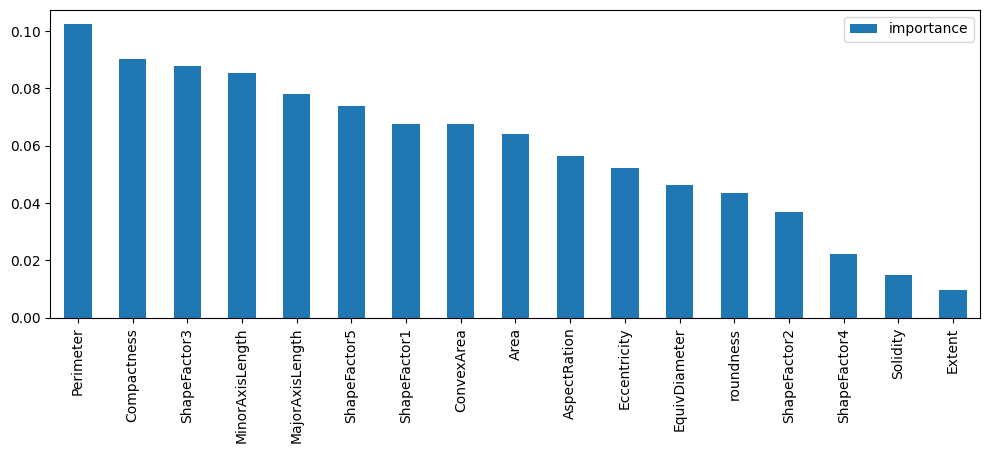

In [5]:
importances = forest.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 4))
feature_importances_sorted = feature_importances.sort_values('importance', ascending=False)
feature_importances_sorted.plot.bar(ax=ax)
ax.set_xticklabels(feature_importances_sorted['feature'])
importance_threshold = feature_importances.max()['importance']

Wynika z tego, że możemy nie brać pod uwagę niektórych kolumn, ale musimy sprawdzić jeszcze, jak dużo z nich usunąć

In [6]:
def evaluate_feature_importance(X, y, importance_threshold):
    forest = RandomForestClassifier(random_state=311)
    forest.fit(X, y)
    importances = forest.feature_importances_

    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_importances = feature_importances.sort_values('importance', ascending=True)

    clf = RandomForestClassifier(random_state=311)
    clf.fit(X, y)

    results = []

    for i in range(len(feature_importances)):
        selected_features = feature_importances['feature'].iloc[i:]

        if feature_importances['importance'].iloc[i] > importance_threshold:
            break

        pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X[selected_features], y, cv=5, scoring='accuracy')

        results.append({
            'num_features': len(selected_features),
            'accuracy': scores.mean(),
            'std': scores.std()
        })

    return pd.DataFrame(results)

In [60]:
results_with_1 = evaluate_feature_importance(X, y, importance_threshold)
results_with_2 = evaluate_feature_importance(X, y, importance_threshold-0.0001)

<Axes: xlabel='num_features'>

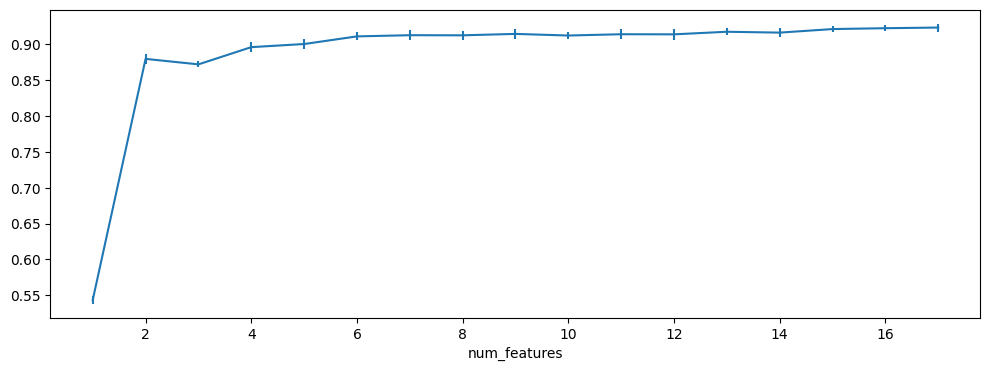

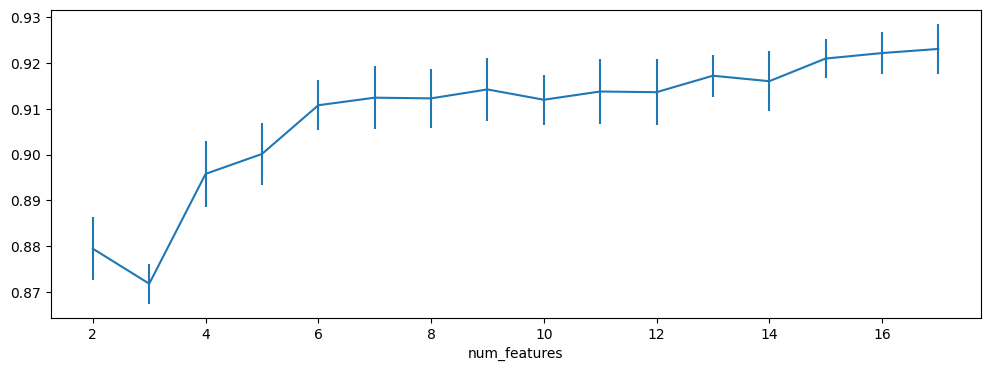

In [61]:
results_with_1.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False)
results_with_2.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False)

Z wykresów wynika, że powinniśmy na pewno usunąć kolumny ShapeFactor2, AspectRatio i ShapeFactor3 ponieważ na wykresie widać, że gdy podczas sekwencyjnego usuwania kolumn, po usunięciu tych trzech accuracy modelu rośnie

Do tego możemy wziąć również pod uwagę kolumny których usuwanie podczas wykonania funkcji *evaluate_feature_importance* nie zmienia znacznie parametru accuracy modelu

# Tutaj coś

In [13]:
features_to_drop1 = ['ShapeFactor2', 'AspectRation', 'ShapeFactor3']
features_to_drop2 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1']
features_to_drop3 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1', 'Extent', 'Solidity', 'ShapeFactor2']

In [63]:
features_to_drop1 = ['ShapeFactor2', 'AspectRation', 'ShapeFactor3']
features_to_drop2 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1']
features_to_drop3 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1', 'Extent', 'Solidity', 'ShapeFactor2']
mask1 = feature_importances['feature'].isin(features_to_drop1)
mask2 = feature_importances['feature'].isin(features_to_drop2)
mask3 = feature_importances['feature'].isin(features_to_drop3)
feature_names1 = feature_importances[~mask1]['feature']
feature_names2 = feature_importances[~mask2]['feature']
feature_names3 = feature_importances[~mask3]['feature']

clf = RandomForestClassifier(random_state=311)

pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
scores1 = cross_val_score(pipeline, X[feature_names1], y, cv=7, scoring='accuracy')
scores2 = cross_val_score(pipeline, X[feature_names2], y, cv=7, scoring='accuracy')
scores3 = cross_val_score(pipeline, X[feature_names3], y, cv=7, scoring='accuracy')

print("Scores\t\tMean\t\tStd")
print("-----\t\t----\t\t---")
print("scores\t\t{0}\t\t{1}".format(round(scores.mean(), 5), round(scores.std(), 5)))
print("scores1\t\t{0}\t\t{1}".format(round(scores1.mean(), 5), round(scores1.std(), 5)))
print("scores2\t\t{0}\t\t{1}".format(round(scores2.mean(), 5), round(scores2.std(), 5)))
print("scores3\t\t{0}\t\t{1}".format(round(scores3.mean(), 5), round(scores3.std(), 5)))


Scores		Mean		Std
-----		----		---
scores		0.92262		0.00485
scores1		0.92397		0.00318
scores2		0.92502		0.00631
scores3		0.91887		0.00804


Okazuje się że możemy usunąć bardzo dużo kolumn bez znacznej utraty accuracy lub usunąć pojedyncze kolumny co daje większą wartość accuracy niż wyjściowe dane. W dalszej części projektu będziemy starali się ustalić które podejście będzie najbardziej efektywne

# Tworzenie Pipeline'ów

In [7]:
def drop_columns(X, columns_to_drop):
    return X.drop(columns=columns_to_drop, axis=1)

In [43]:
# To na razie jeszcze nie działa ale ma potencjał

def test_models_with_dropped_columns(X, y, models, columns_to_drop):
    """
    Test multiple models with different sets of dropped columns.

    Parameters:
    X (DataFrame): The input data
    y (Series or array-like): The target values
    models (list): A list of tuples, where each tuple contains a string (the model name) and a scikit-learn estimator object (the model)
    columns_to_drop (list): A list of lists, where each inner list contains the names of the columns to be dropped

    Returns:
    DataFrame: A DataFrame containing the mean and standard deviation of the accuracy for each combination of model and dropped columns
    """
    results = []
    for model_name, model in models:
        for columns in columns_to_drop:
            X_transformed = drop_columns(X, columns)

            scores = cross_val_score(model, X_transformed, y, cv=5, scoring='accuracy')
            results.append({
                'model' : model_name,
                'columns_dropped' : columns,
                'mean_accuracy' : scores.mean(),
                'std_accuracy' : scores.std()
            })

    return pd.DataFrame(results)

In [16]:
# to do wyjebania jeśli funkcja zadziała

drop_columns_transformer1 = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': features_to_drop1})
drop_columns_transformer2 = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': features_to_drop2})
drop_columns_transformer3 = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': features_to_drop3})

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop1', drop_columns_transformer1, features_to_drop1),
    ])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('drop2', drop_columns_transformer2, features_to_drop2),
    ])

preprocessor3 = ColumnTransformer(
    transformers=[
        ('drop3', drop_columns_transformer3, features_to_drop3),
    ])

In [ ]:
# potestujemy sobie teraz te wybrane kolumny razem ze skalowaniem i bez na gołych modelach: SVC, XGBoost, RandomForest, AdaBoost, LGBM

### Utworzenie wstępnych modeli do testowania wyborów kolumn oraz ich skalowania

In [44]:
models = [('SVC', SVC(random_state=311)), 
          # ('XGBoost', XGBClassifier(random_state=311)), 
          ('RandomForest', RandomForestClassifier(random_state=311)), 
          ('AdaBoost', AdaBoostClassifier(random_state=311)), 
          ('LGBM', LGBMClassifier(random_state=311))
]

columns_to_drop = [
    ['ShapeFactor2', 'AspectRation', 'ShapeFactor3'],
    ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1'],
    ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1', 'Extent', 'Solidity', 'ShapeFactor2']
]


In [45]:
results = test_models_with_dropped_columns(X, y, models, columns_to_drop)

In [46]:
results

,model,columns_dropped,mean_accuracy,std_accuracy
0,SVC,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.634977,0.011289
1,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.858431,0.008980
2,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.864579,0.007896
3,RandomForest,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.924416,0.005444
4,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.922618,0.007175
5,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.919918,0.005576
6,AdaBoost,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.448654,0.229627
7,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.672916,0.013338
8,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.672916,0.013338
9,LGBM,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.927716,0.007357
